# In Codice Ratio Convolutional Neural Network - Test on words

In [1]:
import os.path
from IPython.display import Image

from util import Util
u = Util()
import image_utils as iu

import numpy as np
# Explicit random seed for reproducibility
np.random.seed(1337)

Using TensorFlow backend.


In [2]:
from keras.callbacks import ModelCheckpoint, Callback
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Merge
from keras import backend as K

In [3]:
import dataset_generator as dataset

### Helper function to adjust input

In [4]:
def adjust_input(X):
    if K.image_dim_ordering() == 'th':
        X = X.reshape(X.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        X = X.reshape(X.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)
    X = X.astype('float32')
    X /= 255
    
    return (X, input_shape)

def adjust_input_output(X, y, num_classes=2):
    # convert class vectors to binary class matrices
    Y = np_utils.to_categorical(y, num_classes)
    (X, input_shape) = adjust_input(X)
    
    return (input_shape, X, Y)

In [5]:
# input image dimensions
img_rows, img_cols = 34, 56

(_, _, X_test_22, y_test_22, _) = dataset.generate_all_chars_with_class(verbose=0, plot=False)
(_, _, X_test_seg, y_test_seg) = dataset.generate_dataset_for_segmentator(verbose=0, plot=False)

(input_shape, X_test_22, Y_test_22) = adjust_input_output(X_test_22, y_test_22, 22) 
(_, X_test_seg, Y_test_seg) = adjust_input_output(X_test_seg, y_test_seg, 2) 

## Constants

In [6]:
ALPHABET_ALL = ["a","c","d_mediana","e","i","m","n","o","r","s_mediana","t","u",\
                "d_alta","s_alta","b","f","h","l","g","p","q","s_bassa"]

# number of networks for ensamble learning
number_of_models = 5

# checkpoints dir
checkpoints_dir = "checkpoints"

# size of pooling area for max pooling
pool_size1 = (2, 2)
pool_size2 = (3, 3)
# convolution kernel size
kernel_size1 = (4, 4)
kernel_size2 = (5, 5)
# dropout rate
dropout = 0.15
# activation
activation = 'relu'

## Helper functions for model definition and load

In [7]:
def initialize_network_single_column(model, nb_classes, nb_filters1, nb_filters2, dense_layer_size1):
    model.add(Convolution2D(nb_filters1, kernel_size1[0], kernel_size1[1],
                            border_mode='valid',
                            input_shape=input_shape, name='covolution_1_' + str(nb_filters1) + '_filters'))
    model.add(Activation(activation, name='activation_1_' + activation))
    model.add(MaxPooling2D(pool_size=pool_size1, name='max_pooling_1_' + str(pool_size1) + '_pool_size'))
    model.add(Convolution2D(nb_filters2, kernel_size2[0], kernel_size2[1]))
    model.add(Activation(activation, name='activation_2_' + activation))
    model.add(MaxPooling2D(pool_size=pool_size2, name='max_pooling_1_' + str(pool_size2) + '_pool_size'))
    model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(dense_layer_size1, name='fully_connected_1_' + str(dense_layer_size1) + '_neurons'))
    model.add(Activation(activation, name='activation_3_' + activation))
    model.add(Dropout(dropout))
    model.add(Dense(nb_classes, name='output_' + str(nb_classes) + '_neurons'))
    model.add(Activation('softmax', name='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy', 'precision', 'recall'])

def try_load_checkpoints(model, checkpoints_filepath, warn=True):
    # loading weights from checkpoints 
    if os.path.exists(checkpoints_filepath):
        model.load_weights(checkpoints_filepath)
    elif warn: 
        print('Warning: ' + checkpoints_filepath + ' could not be loaded')

def initialize_network_multi_column(merged_model, models):
    merged_model.add(Merge(models, mode='ave'))
    merged_model.compile(loss='categorical_crossentropy',
                         optimizer='adadelta',
                         metrics=['accuracy', 'precision', 'recall'])

def create_and_load_network(number_of_models, checkpoint_paths, nb_classes, 
                            nb_filters1, nb_filters2, dense_layer_size1):
    # pseudo random generation of seeds
    seeds = np.random.randint(10000, size=number_of_models)

    # initializing all the models
    models = [None] * number_of_models

    for i in range(number_of_models):
        models[i] = Sequential()
        initialize_network_single_column(models[i], nb_classes, nb_filters1, nb_filters2, dense_layer_size1)
        try_load_checkpoints(models[i], checkpoint_paths[i])
        
    # initializing merged model
    merged_model = Sequential()
    initialize_network_multi_column(merged_model, models)
    
    return (merged_model, models)

## Model load

In [8]:
# 22 classes ocr
ocr_weigts_dir = os.path.join(checkpoints_dir, "09_22-classes")

ocr_weights = [os.path.join(ocr_weigts_dir, "09_ICR_weights.best_0.hdf5"), 
               os.path.join(ocr_weigts_dir, "09_ICR_weights.best_1.hdf5"),
               os.path.join(ocr_weigts_dir, "09_ICR_weights.best_2.hdf5"),
               os.path.join(ocr_weigts_dir, "09_ICR_weights.best_3.hdf5"),
               os.path.join(ocr_weigts_dir, "09_ICR_weights.best_4.hdf5")]
(ocr_model, _) = create_and_load_network(5, ocr_weights, 22, 50, 100, 250)
print ("Loaded 22 classes orc model")
print('Evaluating ensemble')
score = ocr_model.evaluate([np.asarray(X_test_22)] * number_of_models, Y_test_22, verbose=0)
print('Test accuracy:', score[1]*100, '%')
print('Test error:', (1-score[2])*100, '%')

# segmentator network (good cut / bad cut)
segmentator_weigts_dir = os.path.join(checkpoints_dir, "letter_not_letter")

segmentator_weights = [os.path.join(segmentator_weigts_dir, "10_ICR_weights.best_0.hdf5"), 
                       os.path.join(segmentator_weigts_dir, "10_ICR_weights.best_1.hdf5"),
                       os.path.join(segmentator_weigts_dir, "10_ICR_weights.best_2.hdf5"),
                       os.path.join(segmentator_weigts_dir, "10_ICR_weights.best_3.hdf5"),
                       os.path.join(segmentator_weigts_dir, "10_ICR_weights.best_4.hdf5")]
(segmentator_model, _) = create_and_load_network(5, segmentator_weights, 2, 30, 50, 200)
print ("Loaded binary segmentator model")
print('Evaluating ensemble')
score = segmentator_model.evaluate([np.asarray(X_test_seg)] * number_of_models, Y_test_seg, verbose=0)
print('Test accuracy:', score[1]*100, '%')
print('Test error:', (1-score[2])*100, '%')
print ("---")

# single letter segmentator / ocr 
single_letter_models = {}
single_letter_weights_dir = {}
single_letter_weights = {}
for char in ALPHABET_ALL:
    single_letter_weights_dir[char] = os.path.join(checkpoints_dir, char + "2")

    single_letter_weights[char] = [os.path.join(single_letter_weights_dir[char], "0.hdf5"), 
                                   os.path.join(single_letter_weights_dir[char], "1.hdf5"),
                                   os.path.join(single_letter_weights_dir[char], "2.hdf5"),
                                   os.path.join(single_letter_weights_dir[char], "3.hdf5"),
                                   os.path.join(single_letter_weights_dir[char], "4.hdf5")]
    (single_letter_models[char], _) = create_and_load_network(5, single_letter_weights[char], 2, 20, 40, 150)
    print ("Loaded binary model for '" + char + "'")

Loaded 22 classes orc model
Evaluating ensemble
Test accuracy: 95.155839279 %
Test error: 4.60439568125 %
Loaded binary segmentator model
Evaluating ensemble
Test accuracy: 93.4960798332 %
Test error: 6.50392016681 %
---
Loaded binary model for 'a'
Loaded binary model for 'c'
Loaded binary model for 'd_mediana'
Loaded binary model for 'e'
Loaded binary model for 'i'
Loaded binary model for 'm'
Loaded binary model for 'n'
Loaded binary model for 'o'
Loaded binary model for 'r'
Loaded binary model for 's_mediana'
Loaded binary model for 't'
Loaded binary model for 'u'
Loaded binary model for 'd_alta'
Loaded binary model for 's_alta'
Loaded binary model for 'b'
Loaded binary model for 'f'
Loaded binary model for 'h'
Loaded binary model for 'l'
Loaded binary model for 'g'
Loaded binary model for 'p'
Loaded binary model for 'q'
Loaded binary model for 's_bassa'


## Helper functions for prediction

In [31]:
def predict_pipeline1(data):
    count = 0
    for bad_cut in data:
        flag = False
        count += 1
        bad_cuts = np.asarray([bad_cut])
        print ("Predictions for the supposed letter number " + str(count))
        for char in ALPHABET_ALL:
            predictions = single_letter_models[char].predict([bad_cuts] * number_of_models)
            if (predictions[0][1] > predictions[0][0]):
                print ("Cut " + str(count) + " has been classified as good corresponding to char '" +\
                       char + "' with a confidence of " + str(predictions[0][1] * 100) + "%")
                flag = True
        if not flag:
            print ("Bad cut")
        print ("---")
        
def predict_pipeline2(data):
    count = 0
    for bad_cut in data:
        count += 1
        bad_cuts = np.asarray([bad_cut])
        print ("Predictions for the supposed letter number " + str(count))
        predictions = segmentator_model.predict([bad_cuts] * number_of_models)
        if (predictions[0][1] > predictions[0][0]):
            predictions = ocr_model.predict([bad_cuts] * number_of_models)
            ind = (-predictions[0]).argsort()[:3]
            for i in ind:
                print ("Good cut corresponding to letter '" + ALPHABET_ALL[i] + \
                   "' with a confidence of " + str(predictions[0][i] * 100) + "%")
        else: 
            print ("Bad cut with a confidence of " + str(predictions[0][0] * 100) + "%")
        print ("---")
        
def predict_pipeline3(data):
    count = 0
    for bad_cut in data:
        flag = False
        count += 1
        bad_cuts = np.asarray([bad_cut])
        print ("Predictions for the supposed letter number " + str(count))
        for char in ALPHABET_ALL:
            predictions = single_letter_models[char].predict([bad_cuts] * number_of_models)
            if (predictions[0][1] > predictions[0][0]):
                print ("Good cut with a confidence of " + str(predictions[0][1] * 100) + "% by letter '" + char + "'")
                flag = True
        if flag:
            predictions = ocr_model.predict([bad_cuts] * number_of_models)
            ind = (-predictions[0]).argsort()[:3]
            for i in ind:
                print ("Good cut corresponding to letter '" + ALPHABET_ALL[i] + \
                   "' with a confidence of " + str(predictions[0][i] * 100) + "%")
        else: 
            print ("Bad cut")
        print ("---")

## Experiment 1 ("afferas")

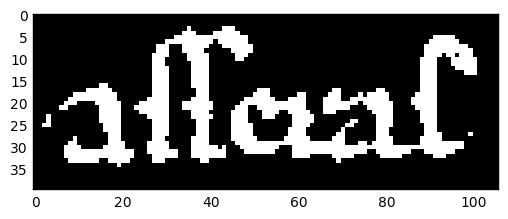

In [21]:
u.plot_image(iu.load_sample("not_code/words/afferas2.png"), (40, 106))

### Bad cuts

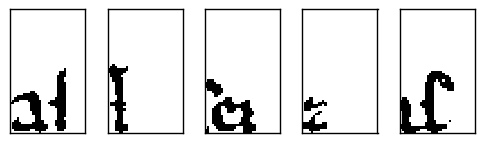

In [22]:
afferas_bad_cuts = iu.open_many_samples( \
                  ["not_code/words/bad_cuts/afferas/1.png",
                   "not_code/words/bad_cuts/afferas/2.png",
                   "not_code/words/bad_cuts/afferas/3.png",
                   "not_code/words/bad_cuts/afferas/4.png",
                   "not_code/words/bad_cuts/afferas/5.png"])
(afferas_bad_cuts, _) = adjust_input(np.asarray(afferas_bad_cuts))

u.plot_some_images(afferas_bad_cuts, (56, 34), grid_x=5, grid_y=1)

#### Pipeline 1 (22 networks as segmentator and classifier)

In [23]:
predict_pipeline1(afferas_bad_cuts)

Predictions for the supposed letter number 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 76.0028541088%
---
Predictions for the supposed letter number 2
Cut 2 has been classified as good corresponding to char 'l' with a confidence of 97.8198885918%
---
Predictions for the supposed letter number 3
Cut 3 has been classified as good corresponding to char 's_mediana' with a confidence of 99.505507946%
---
Predictions for the supposed letter number 4
Bad cut
---
Predictions for the supposed letter number 5
Cut 5 has been classified as good corresponding to char 's_mediana' with a confidence of 94.7523236275%
Cut 5 has been classified as good corresponding to char 's_alta' with a confidence of 61.3462090492%
---


#### Pipeline 2 (segmentator + classifier)

In [32]:
predict_pipeline2(afferas_bad_cuts)

Predictions for the supposed letter number 1
Bad cut with a confidence of 99.9990284443%
---
Predictions for the supposed letter number 2
Bad cut with a confidence of 53.2761394978%
---
Predictions for the supposed letter number 3
Bad cut with a confidence of 93.2435631752%
---
Predictions for the supposed letter number 4
Bad cut with a confidence of 94.3567276001%
---
Predictions for the supposed letter number 5
Good cut corresponding to letter 's_alta' with a confidence of 95.2699542046%
Good cut corresponding to letter 'f' with a confidence of 4.72010560334%
Good cut corresponding to letter 's_bassa' with a confidence of 0.00890376686584%
---


#### Pipeline 3 (22 networks as segmentator + classifier)

In [33]:
predict_pipeline3(afferas_bad_cuts)

Predictions for the supposed letter number 1
Good cut with a confidence of 76.0028541088% by letter 's_mediana'
Good cut corresponding to letter 'b' with a confidence of 92.1378970146%
Good cut corresponding to letter 'h' with a confidence of 7.86172300577%
Good cut corresponding to letter 'q' with a confidence of 0.000168871667938%
---
Predictions for the supposed letter number 2
Good cut with a confidence of 97.8198885918% by letter 'l'
Good cut corresponding to letter 'l' with a confidence of 99.9999880791%
Good cut corresponding to letter 's_alta' with a confidence of 1.0037138054e-05%
Good cut corresponding to letter 'h' with a confidence of 6.2676763779e-08%
---
Predictions for the supposed letter number 3
Good cut with a confidence of 99.505507946% by letter 's_mediana'
Good cut corresponding to letter 'd_alta' with a confidence of 96.7134594917%
Good cut corresponding to letter 's_mediana' with a confidence of 2.20283605158%
Good cut corresponding to letter 'b' with a confidenc

### Good cuts

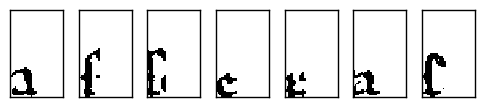

In [26]:
afferas_good_cuts = iu.open_many_samples( \
                    ["not_code/words/good_cuts/afferas/a1.png",
                     "not_code/words/good_cuts/afferas/f1.png",
                     "not_code/words/good_cuts/afferas/f2.png",
                     "not_code/words/good_cuts/afferas/e.png",
                     "not_code/words/good_cuts/afferas/r.png",
                     "not_code/words/good_cuts/afferas/a2.png",
                     "not_code/words/good_cuts/afferas/s.png"])
(afferas_good_cuts, _) = adjust_input(np.asarray(afferas_good_cuts))

u.plot_some_images(afferas_good_cuts, (56, 34), grid_x=7, grid_y=1)

#### Pipeline 1 (22 networks as segmentator and classifier)

In [27]:
predict_pipeline1(afferas_good_cuts)

Predictions for the supposed letter number 1
Cut 1 has been classified as good corresponding to char 'a' with a confidence of 83.2198321819%
---
Predictions for the supposed letter number 2
Cut 2 has been classified as good corresponding to char 's_mediana' with a confidence of 84.6229910851%
Cut 2 has been classified as good corresponding to char 's_alta' with a confidence of 86.5796089172%
---
Predictions for the supposed letter number 3
Cut 3 has been classified as good corresponding to char 's_mediana' with a confidence of 84.2514634132%
---
Predictions for the supposed letter number 4
Cut 4 has been classified as good corresponding to char 'e' with a confidence of 56.4199745655%
---
Predictions for the supposed letter number 5
Cut 5 has been classified as good corresponding to char 'r' with a confidence of 70.5377936363%
---
Predictions for the supposed letter number 6
Cut 6 has been classified as good corresponding to char 'a' with a confidence of 88.8050854206%
---
Predictions f

#### Pipeline 2 (segmentator + classifier)

In [34]:
predict_pipeline2(afferas_good_cuts)

Predictions for the supposed letter number 1
Good cut corresponding to letter 'a' with a confidence of 99.9539852142%
Good cut corresponding to letter 'i' with a confidence of 0.0380926794605%
Good cut corresponding to letter 'o' with a confidence of 0.00474102635053%
---
Predictions for the supposed letter number 2
Good cut corresponding to letter 's_alta' with a confidence of 97.454893589%
Good cut corresponding to letter 'l' with a confidence of 2.23840679973%
Good cut corresponding to letter 'f' with a confidence of 0.306030525826%
---
Predictions for the supposed letter number 3
Good cut corresponding to letter 's_alta' with a confidence of 77.089202404%
Good cut corresponding to letter 'l' with a confidence of 22.8763625026%
Good cut corresponding to letter 'f' with a confidence of 0.0277649669442%
---
Predictions for the supposed letter number 4
Good cut corresponding to letter 'e' with a confidence of 97.1935749054%
Good cut corresponding to letter 'c' with a confidence of 2.25

#### Pipeline 3 (22 networks as segmentator + classifier)

In [36]:
predict_pipeline3(afferas_good_cuts)

Predictions for the supposed letter number 1
Good cut with a confidence of 83.2198321819% by letter 'a'
Good cut corresponding to letter 'a' with a confidence of 99.9539852142%
Good cut corresponding to letter 'i' with a confidence of 0.0380926794605%
Good cut corresponding to letter 'o' with a confidence of 0.00474102635053%
---
Predictions for the supposed letter number 2
Good cut with a confidence of 84.6229910851% by letter 's_mediana'
Good cut with a confidence of 86.5796089172% by letter 's_alta'
Good cut corresponding to letter 's_alta' with a confidence of 97.454893589%
Good cut corresponding to letter 'l' with a confidence of 2.23840679973%
Good cut corresponding to letter 'f' with a confidence of 0.306030525826%
---
Predictions for the supposed letter number 3
Good cut with a confidence of 84.2514634132% by letter 's_mediana'
Good cut corresponding to letter 's_alta' with a confidence of 77.089202404%
Good cut corresponding to letter 'l' with a confidence of 22.8763625026%
Go